# Queue Imbalance as a One-Tick-Ahead Price Predictor in LOB for large roc


Order of this notebook is as follows:
1. [Data](#Data)
2. [Methodology](#Methodology)
3. [Results](#Results)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks from 2013-09 - 2013-11. The market is open between 8-16 on weekdays, so we use the data from 9-15 to avoid having data affected by the abnormal trading behaviour, which usually occurs right after opening or closing auction. The tick size is $\pi = 0.01$ for the market, but the *relative tick size*(the ratio between stock price and $\pi$) for each stock differs.

To each stock data we introduce:

* bid price: $$ b(t) := \underset{\{x \in bidList(t) \}}{\max} x.price $$
* ask price: $$ a(t) := \underset{\{x \in askList(t)\}}{\min} x.price $$

* total size of active buy orders: $$ n^{b}(p, t) = \sum_{\{x \in buyList(t), p_x = p\}} x.volumen $$

* total size of active sell orders: $$ n^{a}(p, t) = \sum_{\{x \in askList(t), p_x = p\}} x.volumen $$


* mid price: $$ m(t) := \frac{a(t) + b(t)}{2} $$

* queue imbalance: $$ I(t) := \frac{n^b (b_t , t) - n^a (a_t, t)}{n^b (b_t , t) + n^a (a_t, t)} $$ where $a_t$ and $b_t$ are ask and bid prices for time $t$ respectively.

* mid price indicator: $$ y_i = \begin{cases} 1 & \text{if} & m(t_i) > m(t_{i-1})\\ 0 & \text{if} & m(t_i) < m(t_{i-1})\\ \end{cases} $$

Based on the **queue imbalance** we will try to predict **mid price indicator**

In [2]:
dfs = {}
dfs_test = {}
stocks = ['3757', '4218', '4851', '3388', '3107']
print(len(stocks))

for s in stocks:
    d, d_test = lob.load_prepared_data(s)
    dfs[s] = d
    dfs_test[s] = d_test

5
Training set length for 3757: 5839
Testing set length for 3757: 1459
Training set length for 4218: 5815
Testing set length for 4218: 1453
Training set length for 4851: 4422
Testing set length for 4851: 1105
Training set length for 3388: 5310
Testing set length for 3388: 1327
Training set length for 3107: 4640
Testing set length for 3107: 1159


### Description of DataFrame

The data is indexed with time $t$.

* `bid` - bid queue
* `ask` - ask queue
* `bid_price` - bid price $b(t)$
* `ask_price` - ask price $a(t)$
* `mid_price` - mid price $m(t)$
* `sum_sell_ask` - total size of active sell orders for ask price  $ n^{a}(a(t), t) $
* `sum_buy_bid` - total size of active buy orders for bid price  $ n^{b}(b(t), t) $
* `mid_price_indicator` - the indicator if the mid price will rise in the **next** time tick
* `queue_imbalance` - $I(t)$

In [3]:
dfs[stocks[0]].head(10)

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1459,2013-09-12 14:05:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 2809.0), (1620.0, 4290.0), (1621.0, ...",1616.0,1619.0,1617.5,2809.0,1101.0,0.0,-0.436829
1460,2013-09-12 14:15:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1618.0, 619.0), (1619.0, 2439.0), (1620.0, 3...",1616.0,1618.0,1617.0,619.0,698.0,1.0,0.059985
1461,2013-09-12 14:19:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1618.0, 334.0), (1619.0, 2629.0), (1620.0, 4...",1617.0,1618.0,1617.5,334.0,108.0,1.0,-0.511312
1462,2013-09-12 14:20:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 1794.0), (1620.0, 3025.0), (1621.0, ...",1617.0,1619.0,1618.0,1794.0,724.0,1.0,-0.424940
1463,2013-09-12 14:28:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 694.0), (1620.0, 1132.0), (1621.0, 2...",1618.0,1619.0,1618.5,694.0,246.0,1.0,-0.476596
1464,2013-09-12 14:31:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1622.0, 1768.0), (1623.0, 4273.0), (1624.0, ...",1620.0,1622.0,1621.0,1768.0,605.0,0.0,-0.490097
1465,2013-09-12 14:32:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1620.0, 1678.0), (1621.0, 1647.0), (1622.0, ...",1618.0,1620.0,1619.0,1678.0,675.0,0.0,-0.426264
1466,2013-09-12 14:34:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 505.0), (1620.0, 2689.0), (1621.0, 2...",1617.0,1619.0,1618.0,505.0,233.0,1.0,-0.368564
1467,2013-09-12 14:35:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1620.0, 2689.0), (1621.0, 2966.0), (1622.0, ...",1617.0,1620.0,1618.5,2689.0,1835.0,0.0,-0.188771
1468,2013-09-12 14:36:00,"[(1320.0, 15.0), (1500.0, 250.0), (1520.0, 250...","[(1619.0, 470.0), (1620.0, 2677.0), (1621.0, 4...",1617.0,1619.0,1618.0,470.0,1541.0,0.0,0.532571


### Stock characteristic

For each stock we want to know how the can compare the *relative tick size* as the authors of [[1]](#Resources) saw it's is relevant for predictions. They decided that stocks are: 

* *large-tick stocks* when **maximal trade price** was below $50.00$
* *small-tick stocks* when **minimal trade price** was above $100.00$

They found out that the stocks which were between these two tresholds could behave similarily to both of these groups. 
    
The means of $n^{b}(b(t), t)$ and $n^{a}(a(t), t)$ for:

* *large-tick* stocks were above 3000 
* *small-tick* stocks were below 200

The bid ask spread for:

* *large-tick* stocks was below 0.02
* *small-tick* stocks was above 0.2

In [4]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []

for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())

df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary.head()

,sum_sell_ask_mean,sum_buy_bid_mean,max_trade_price,min_trade_price,bid_ask_spread
3757,1227.341154,1053.624765,1690.0,1510.0,1.923788
4218,1316.987962,1421.634050,1898.0,1740.0,1.806019
4851,6906.441882,6958.193804,739.5,680.0,0.713817
3388,2005.248964,2019.872316,1426.0,1288.0,1.664407
3107,2511.361422,2510.594828,1300.0,1190.0,1.631034


# Methodology 

We perform classification using logistic regression.

### Sample construction

As the authors of the [[1]](#Resources) didn't see difference in sampling in-between data samples we stick to the original timestamps of the events. We also tried to pick 100 samples per day, but it didn't lead to better results.

### Data in-sample and out-of-sample

Test set is 20% of data we have, the rest 80% is training set - we pick data from first two weeks of 2013-09 as test data. 

The authors used 25200 data points per stock, we have about 12000 per stock. Authors randomly picked the time range with 20% of data for training set. They picked randomly about 100 points for each day instead of using all the data they had.

We tried to do similar sampling, but with 200 and 300 points per day, it didn't bring any different results. But we have data for only 2 months, instead of 12 months, so this approach cuts the amount of data drastically.

### Formulating predictions with logistic regression

We perform a logistic regression of mid price indicator $y$ based on queue imbalance $I$. Specifically, we use the data in our training set to calculate
maximum likelihood estimates of the coefficients $x_0$ and $x_1$:

$$ \hat{y}(I) = \frac{1}{1 + e^{-(x_0 + Ix_1 )}}$$

If $\hat{y}(I) > \frac{1}{2}$ we predict that the mid price will raise in the next tick.

In [5]:
reg = {}

for s in stocks:
    reg[s] = lob.logistic_regression(dfs[s], 0, len(dfs[s]))

In [6]:
pred_in_sample = {}
pred_out_of_sample = {}
for s in stocks:
    pred_in_sample[s] = reg[s].predict(dfs[s]['queue_imbalance'].values.reshape(-1, 1))
    pred_out_of_sample[s] = reg[s].predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))

# Results

## Distribution of $I$

### Denisty plot

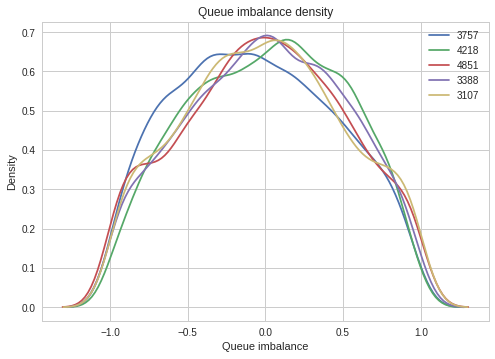

In [7]:
for s in stocks:
    sns.kdeplot(np.array(dfs[s]['queue_imbalance']), label=s)

plt.legend()
plt.xlabel('Queue imbalance')
plt.ylabel('Density')
plt.title('Queue imbalance density')

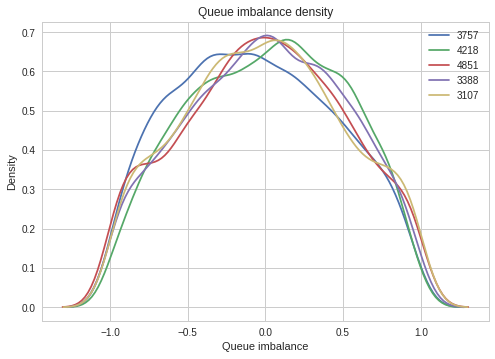

In [8]:
for s in stocks:
    sns.kdeplot(np.array(dfs[s]['queue_imbalance']), label=s)

plt.legend()
plt.xlabel('Queue imbalance')
plt.ylabel('Density')
plt.title('Queue imbalance density')

### ECDF curve

The ECDF (emprical cumulative density functions) curve of the bid and ask prices queue lengths is smooth, which indicates that the queues lengths differ. 

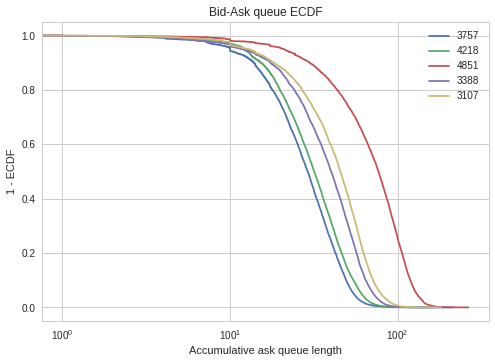

In [9]:
ax = plt.subplot()
ax.set_xscale("log", basex=100)
for s in stocks:
    ecdf = ECDF(np.append(dfs[s]['sum_buy_bid'], dfs[s]['sum_sell_ask']))
    e = 1 - ecdf.y
    plt.plot(ecdf.x, e, label=s)
plt.legend()
plt.legend()
plt.ylabel('1 - ECDF')
plt.xlabel('Accumulative ask queue length')
plt.title('Bid-Ask queue ECDF')

## Logistic Regression fits


### Likelihood estimates
$$ \hat{y}(I) = \frac{1}{1 + e^{-(x_0 + Ix_1 )}}$$

We can see that $x_0$ value is small - this suggests that there is a symmetric behaviour in terms of buying and selling activity.

The $x_1$ is positive in each case.
This implies that the logistic regression line is an increasing function. So that 
suggests that the larger the queue imbalance, the higher the probability that the next mid-price will go up.

In [[1]](#Resources) the authors noticed that the fitted values of $x_1$ are much larger for large-tick stocks (for which
they vary from about 2 to about 3) than for small-tick stocks (for which they
vary from about 0.5 to about 0.8).

In [10]:
df_reg = pd.DataFrame(index=stocks)
x1 = []
x0 = []
for s in stocks:
    x1.append(reg[s].coef_[0][0])
    x0.append(reg[s].intercept_[0])
df_reg['x1'] = x1
df_reg['x0'] = x0
df_reg.head()

,x1,x0
3757,0.177306,0.016810
4218,0.868627,0.004707
4851,0.655769,-0.001051
3388,0.624725,0.019799
3107,0.189945,0.005652


### Fitted logistic regression curves

The fitted curves are monotonically increasing. 
They look almost like a straingth lines, which is more charactersitc to the *small-tick* stocks according to [[1]](#Resources).

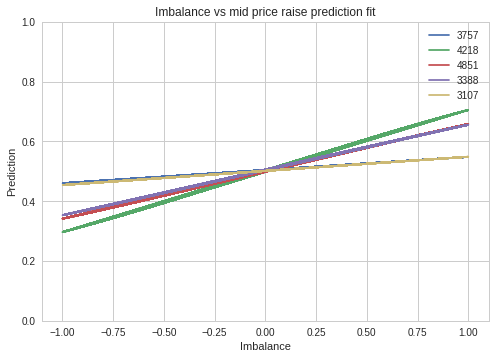

In [11]:
for s in stocks:
    plt.plot(dfs[s]['queue_imbalance'].values, 
             lob.sigmoid(reg[s].coef_[0] * dfs[s]['queue_imbalance'].values + reg[s].intercept_), '-', label=s)
plt.title('Imbalance vs mid price raise prediction fit')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')
plt.ylim(0, 1)
plt.legend()

## Assessing predictions for logistic regression

### Mean square error 

We calculate residual $r_i$:

$$ r_i = \hat{y_i} - y_i $$

We use mean square residual on testing set to assess the predictive power.

In [12]:
for s in stocks:
    err = ((dfs_test[s]['mid_price_indicator'].values - reg[s].predict_proba(
        dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))[:,1]) ** 2).mean()
    print('Error for {} is {}'.format(s, err))

Error for 3757 is 0.2452230630510241
Error for 4218 is 0.23663008773487487
Error for 4851 is 0.23981557525879207
Error for 3388 is 0.23730233256107452
Error for 3107 is 0.24410074803714396


### ROC curves

We calculate the out-of-sample ROC curves and area-under-ROC-curve statistics to
assess the predectivity power of logistic regressions.

3757 (area = 0.595696913881893)
4218 (area = 0.6132356451851263)
4851 (area = 0.5868567682726975)
3388 (area = 0.601259405760531)
3107 (area = 0.6099603848330504)


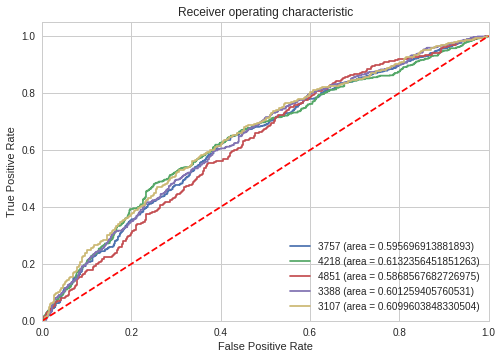

In [13]:
for s in stocks:
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_out_of_sample[s])
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, 
                                     reg[s].predict_proba(dfs_test[s]['queue_imbalance'].reshape(-1, 1))[:,1])
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
    print('{} (area = {})'.format(s, logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [14]:
from sklearn.metrics import classification_report
for s in stocks:
    print(s)
    print(classification_report(pred_in_sample[s], dfs[s]['mid_price_indicator'].values))
    print()

3757
             precision    recall  f1-score   support

        0.0       0.57      0.58      0.58      2864
        1.0       0.59      0.58      0.59      2975

avg / total       0.58      0.58      0.58      5839


4218
             precision    recall  f1-score   support

        0.0       0.56      0.59      0.58      2759
        1.0       0.61      0.59      0.60      3056

avg / total       0.59      0.59      0.59      5815


4851
             precision    recall  f1-score   support

        0.0       0.61      0.61      0.61      2229
        1.0       0.60      0.61      0.61      2193

avg / total       0.61      0.61      0.61      4422


3388
             precision    recall  f1-score   support

        0.0       0.57      0.60      0.58      2486
        1.0       0.63      0.60      0.61      2824

avg / total       0.60      0.60      0.60      5310


3107
             precision    recall  f1-score   support

        0.0       0.59      0.62      0.60      2237
    

# Conclusions


### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>